This study demonstrates how to classify a highly imbalanced dataset in which the number of examples in one class greatly outnumbers the examples in another.  This work contains complete code to:

* Load a CSV file using Pandas.
* Create train, validation, and test sets.
* Define and train a model using Keras (including setting class weights).
* Evaluate the model using various metrics (including precision and recall).
* Try common techniques for dealing with imbalanced data like:
* Class weighting
* Oversampling

In [2]:
import tensorflow as tf
from tensorflow import keras

import os, tempfile

import matplotlib as mpl, matplotlib.pyplot as plt
import numpy as np, pandas as pd, seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [3]:
#Data Processing
#Download the kaggle Credit Card Fraud data set

file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [4]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [7]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos
print('Examples:\n  Total: {}\n  Positive: {} ({:.2f}% of total)\n'.format(total, pos, 100 * pos / total))

Examples:
  Total: 284807
  Positive: 492 (0.17% of total)



In [17]:
#Clean, split and Normalize data
#The `Amount` column covers a huge range. Convert to log-space to reduce its range.

cleaned_df = raw_df.copy()
cleaned_df.pop('Time')

eps = 0.001
cleaned_df['Log Amount'] = np.log(cleaned_df.pop('Amount') + eps)

######################################################################
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0

val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

In [18]:
#The StandardScaler is only fit using the train_features to be sure the model is not peeking at the validation or test sets.
scaler = StandardScaler()

train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('Training lables shape:', train_labels.shape)
print('validation lables shape:', val_labels.shape)
print('Test lables shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training lables shape: (182276,)
validation lables shape: (45569,)
Test lables shape: (56962,)
Training features shape: (182276, 29)
validation features shape: (45569, 29)
Test features shape: (56962, 29)


In [19]:
#If you want to deploy a model, it's critical that you preserve the preprocessing calculations.
#The easiest way to implement them as layers, and attach them to your model before export.

/home/ubuntu/anaconda3/envs/technical-test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/ubuntu/anaconda3/envs/technical-test/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


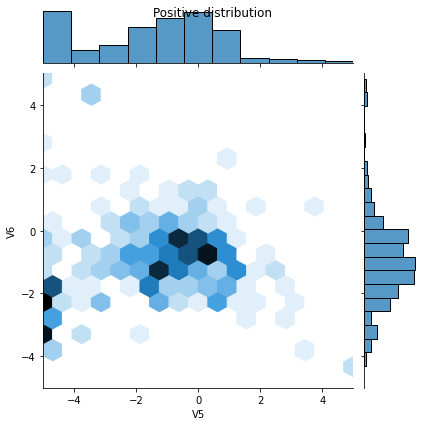

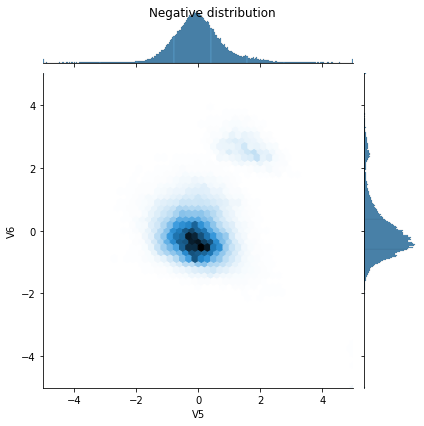

In [22]:
#Let's Look at the data distribution
pos_df = pd.DataFrame(train_features[bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'], pos_df['V6'], kind='hex', xlim=(-5,5), ylim=(-5, 5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'], neg_df['V6'], kind='hex', xlim=(-5,5), ylim=(-5,5))
_ = plt.suptitle("Negative distribution")

Next compare the distributions of the positive and negative examples over a few features. Good questions to ask at this point are:

* Do these distributions make sense?
    * Yes. You've normalized the input and these are mostly concentrated in the +/- 2 range.
* Can you see the difference between the distributions?
    * Yes the positive examples contain a much higher rate of extreme values.
    
Next Let's define the model and metrics:
    * Define a function that creates a simple neural network with a densly connected hidden layer, a dropout layer to reduce overfitting, and an output sigmoid layer that returns the probability of a transaction being fraudulent

In [24]:
METRICS = [
    keras.metrics.TruePositives(name='tp'),
    keras.metrics.FalsePositives(name='fp'),
    keras.metrics.TrueNegatives(name='tn'),
    keras.metrics.FalseNegatives(name='fn'),
    keras.metrics.BinaryAccuracy(name='accuracy'),
    keras.metrics.Precision(name='precision'),
    keras.metrics.Recall(name='recall'),
    keras.metrics.AUC(name='auc'),
]

def make_model(metrics=METRICS, output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = keras.Sequential([keras.layers.Dense(16, activation='relu', input_shape=(train_features.shape[-1], )),
                                                keras.layers.Dropout(0.5),
                                                keras.layers.Dense(1, activation='sigmoid', bias_initializer=output_bias)])
    model.compile(optimizer=keras.optimizers.Adam(lr=1e-3), 
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics)
    return model

#### Understanding useful metrics
Notice that there are a few metrics defined above that can be computed by the model that will be helpful when evaluating the performance.

 * **False negatives** and **false positives** are samples that were **incorrectly classified**
 * **True negatives** and **true positives** are samples that were **correctly classified**
 * **Accuracy** is the percentage of examples correctly classified > **True samples / total samples**
 * **Precision** is the percentage of predicted positives that were correctly classified > **True Positive / (True positive + False positive)**
 * **Recall** is the percentage of actual positives that were correctly classified > **True Positives / (True positives + False Negative)**
 * **AUC** refers to the Area Under the Curve of a Receiver Operating Characteristic curve (ROC-AUC). This metric is equal to the probability that a classifier will rank a random positive sample higher than a random negative sample.
 
Notice that the model is fit using a larger than default batch size of 2048, this is important to ensure that each batch has a decent chance of containing a few positive samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from

In [25]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_auc',
                                                 verbose=1,
                                                 patience=10,
                                                 mode='max',
                                                 restore_best_weights=True)

In [26]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


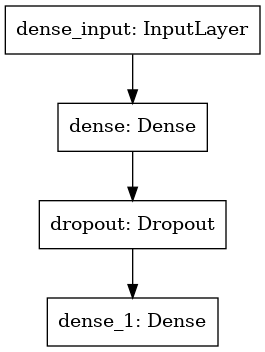

In [27]:
tf.keras.utils.plot_model(model)

In [33]:
#Let's test the untrained model
model.predict(train_features[:10])

array([[0.03602034],
       [0.01028278],
       [0.18860397],
       [0.10897079],
       [0.09464434],
       [0.10991278],
       [0.00590822],
       [0.10254371],
       [0.06027427],
       [0.09244975]], dtype=float32)

#### Set the correct initial bias
These initial guesses are not great. We know the dataset is imbalanced. Let's set the output layer's bias to reflect that [See: A Recipe for Training Neural Networks: "init well"](http://karpathy.github.io/2019/04/25/recipe/#2-set-up-the-end-to-end-trainingevaluation-skeleton--get-dumb-baselines). This can help with initial convergence.

With the default bias initialization the loss should be about **math.log(2) = 0.69314 ?**

In [36]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0])) #Initial Loss

Loss: 0.1052


The correct bias to set can be derived from:
$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$ 

In [38]:
initial_bias = np.log([pos/neg])
initial_bias
#set that as the initial bias, and the model will give much more reasonable initial guesses. 
#Initial predictions should be close to pos/total = 0.00172

array([-6.35935934])

In [40]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00149223],
       [0.00936955],
       [0.00244066],
       [0.00149724],
       [0.00188413],
       [0.00266704],
       [0.6623065 ],
       [0.00344568],
       [0.00107625],
       [0.00290415]], dtype=float32)

With this initialization the **initial loss** should be approximately but certainly lower than the previous:
$$ -{p}_{0} log({p}_{0}) - (1 - {p}_{0}) log(1 - {p}_{0}) = 0.01317 $$

In [45]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print('Loss: {:0.4f}'.format(results[0]))

Loss: 0.0201


Let's Checkpoint the initial weights to make the various runs more comparable. Keep this initial weights in a checkpoint file and load them into each model before training.

In [46]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

**Let's confirm that the initial bias fix help by training 20 epochs with and without this careful initialization and compare the Losses**

In [47]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])

zero_bias_history = model.fit(train_features,
                             train_labels,
                             batch_size=BATCH_SIZE,
                             epochs=20,
                             validation_data=(val_features, val_labels),
                             verbose=0)

In [59]:
model = make_model()
model.load_weights(initial_weights)

careful_bias_history = model.fit(train_features,
                                train_labels,
                                batch_size=BATCH_SIZE,
                                epochs = 20,
                                validation_data=(val_features, val_labels),
                                verbose=0)

In [52]:
def plot_loss(history, label, n):
    plt.semilogy(history.epoch, history.history['loss'], color=colors[n], label='Train ' + label) 
    plt.semilogy(history.epoch, history.history['val_loss'], color=colors[n], label='Val ' + label, linestyle="--")

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

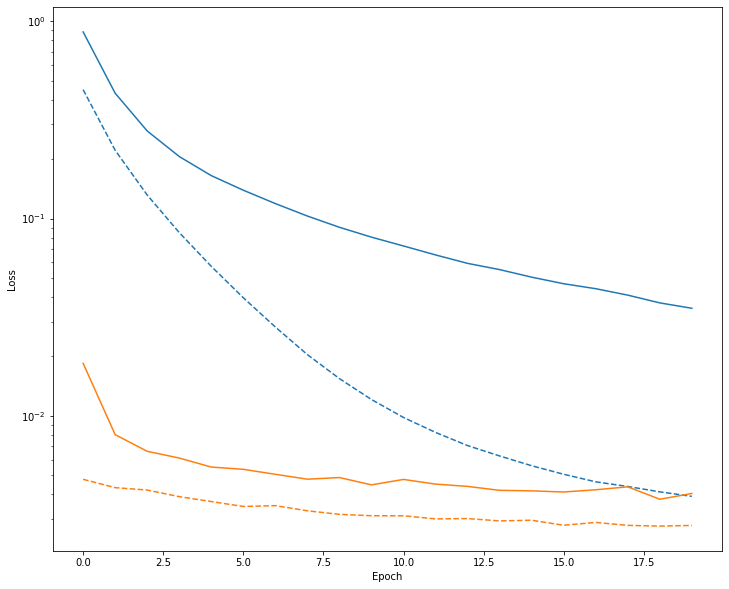

In [60]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

The above figure makes it clear: In terms of validation loss, on this problem, this careful initialization gives a clear advantage.

Now Let's Train the model

In [61]:
model = make_model()
model.load_weights(initial_weights)
base_line_history = model.fit(train_features,
                             train_labels,
                             batch_size=BATCH_SIZE,
                             epochs=EPOCHS,
                             callbacks=[early_stopping],
                             validation_data=(val_features, val_labels)
                             )

Epoch 1/100
90/90 [==============================] - 3s 19ms/step - loss: 0.0256 - tp: 114.6374 - fp: 299.3516 - tn: 139188.4176 - fn: 107.1648 - accuracy: 0.9972 - precision: 0.2916 - recall: 0.5427 - auc: 0.8840 - val_loss: 0.0048 - val_tp: 45.0000 - val_fp: 10.0000 - val_tn: 45493.0000 - val_fn: 21.0000 - val_accuracy: 0.9993 - val_precision: 0.8182 - val_recall: 0.6818 - val_auc: 0.9276
Epoch 2/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0088 - tp: 84.7033 - fp: 50.6703 - tn: 93929.5165 - fn: 75.6813 - accuracy: 0.9986 - precision: 0.6139 - recall: 0.5473 - auc: 0.9031 - val_loss: 0.0043 - val_tp: 46.0000 - val_fp: 10.0000 - val_tn: 45493.0000 - val_fn: 20.0000 - val_accuracy: 0.9993 - val_precision: 0.8214 - val_recall: 0.6970 - val_auc: 0.9154
Epoch 3/100
90/90 [==============================] - 1s 8ms/step - loss: 0.0070 - tp: 88.2527 - fp: 22.5165 - tn: 93956.7143 - fn: 73.0879 - accuracy: 0.9989 - precision: 0.7697 - recall: 0.5185 - auc: 0.9132 - val_lo